In [1]:
%load_ext autoreload
%autoreload 2

In [449]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

from dataset import dataframe_to_dataset
from neural import run_grn_and_vsn_model, run_tabtransformer_model

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, SplineTransformer, RobustScaler, MaxAbsScaler, MinMaxScaler, QuantileTransformer, KBinsDiscretizer
from preprocessing import process_dataset, get_where_all_are_non_null, expand_cabin, expand_name, expand_passenger_id_to_group, impute_missing_values, fill_age_column, fill_missing_categorical_columns

sns.set_theme()

DATASET_PATH = "/Users/dincaus/datasets/spaceship-titanic"

TRAIN_PATH = os.path.join(DATASET_PATH, "train.csv")
TEST_PATH = os.path.join(DATASET_PATH, "test.csv")

In [451]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [482]:
all_data = pd.concat([train_df, test_df], axis=0)

all_data[["Deck", "CabinNumber", "Side"]] = expand_cabin(all_data)
all_data["PassengerGroup"] = expand_passenger_id_to_group(all_data)
all_data[["FirstName", "LastName"]] = expand_name(all_data)

all_data = all_data.drop(columns=["Name", "Cabin"]).reset_index(drop=True)

In [483]:
last_name_mapping = pd.concat([all_data.groupby(by="LastName")["LastName"].count().rename("Count"), pd.Series([all_data.groupby(by="LastName")["LastName"].count().rename("Count").mode()[0]], index=[np.nan])])

all_data["FamilySize"] = all_data["LastName"].apply(lambda x: last_name_mapping[x])

In [484]:
# NUMERICAL_FEATURES = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "FamilySize"]
# BOOL_FEATURES = ["VIP", "CryoSleep"]
# CATEGORICAL_FEATURES = ["HomePlanet", "Destination", "Deck", "Side"]

NUMERICAL_FEATURES = ["Age", "RoomService", "Spa", "VRDeck", "FoodCourt", "FamilySize", "ShoppingMall"]
BOOL_FEATURES = ["VIP", "CryoSleep"]
CATEGORICAL_FEATURES = ["HomePlanet", "Deck", "Side", "Destination"]

knn_imputer = KNNImputer(n_neighbors=10)

all_data[NUMERICAL_FEATURES] = knn_imputer.fit_transform(all_data[NUMERICAL_FEATURES].to_numpy())

all_data["VIP"] = SimpleImputer(strategy="most_frequent").fit_transform(all_data["VIP"].to_numpy().reshape(-1, 1)).astype(np.int64)
all_data["CryoSleep"] = SimpleImputer(strategy="most_frequent").fit_transform(all_data["CryoSleep"].to_numpy().reshape(-1, 1)).astype(np.int64)

all_data["HomePlanet"] = SimpleImputer(strategy="most_frequent").fit_transform(all_data["HomePlanet"].to_numpy().reshape(-1, 1))
all_data["Destination"] = SimpleImputer(strategy="most_frequent").fit_transform(all_data["Destination"].to_numpy().reshape(-1, 1))
all_data["Deck"] = SimpleImputer(strategy="most_frequent").fit_transform(all_data["Deck"].to_numpy().reshape(-1, 1))
all_data["Side"] = SimpleImputer(strategy="most_frequent").fit_transform(all_data["Side"].to_numpy().reshape(-1, 1))

# for numerical_feat in NUMERICAL_FEATURES:
#     if numerical_feat in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", ]:
#         all_data[numerical_feat] = StandardScaler().fit_transform(all_data[numerical_feat].to_numpy().reshape(-1, 1))
#     elif numerical_feat in ["Age", "FamilySize"]:
#         all_data[numerical_feat] = StandardScaler().fit_transform(all_data[numerical_feat].to_numpy().reshape(-1, 1))

In [485]:
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "HomePlanet": list(all_data["HomePlanet"].unique()),
    "Destination": list(all_data["Destination"].unique()),
    "Deck": list(all_data["Deck"].unique()),
    "Side": list(all_data["Side"].unique())
}

In [ ]:
train_data = all_data[~all_data["Transported"].isna()]
train_data["Transported"] = train_data["Transported"].astype(np.int32)

test_data = all_data[all_data["Transported"].isna()]

# model, history_result = run_grn_and_vsn_model(
#     train_df=train_data,
#     numerical_features=NUMERICAL_FEATURES + BOOL_FEATURES,
#     categorical_features=CATEGORICAL_FEATURES,
#     categorical_features_with_vocabulary=CATEGORICAL_FEATURES_WITH_VOCABULARY,
#     label_cols=["Transported", ],
#     epochs=200,
#     learning_rate=1e-3,
#     dropout_rate=0.2,
#     encoding_size=64,
#     batch_size=256,
#     shuffle=True,
#     test_size=0.05,
#     number_of_splits=4
# )

model, history_result = run_tabtransformer_model(
    train_df=train_data,
    numerical_features=NUMERICAL_FEATURES + BOOL_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    categorical_features_with_vocabulary=CATEGORICAL_FEATURES_WITH_VOCABULARY,
    label_cols=["Transported", ],
    epochs=200,
    learning_rate=1e-3,
    dropout_rate=0.1,
    batch_size=256,
    num_transformer_blocks=6,
    num_heads=8,
    embedding_dims=32,
    mlp_hidden_units_factors=[4, 2],
    shuffle=True,
    test_size=0.1,
    number_of_splits=3
)

/var/folders/jy/0x3dtb595998ft_1332l_k780000gn/T/ipykernel_20883/3799521453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Transported"] = train_data["Transported"].astype(np.int32)
/Users/dincaus/miniconda3/envs/tf_keras_2_0/lib/python3.9/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 HomePlanet (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Deck (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Side (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Destination (InputLayer)       [(None,)]            0           []                               
                                                                                           

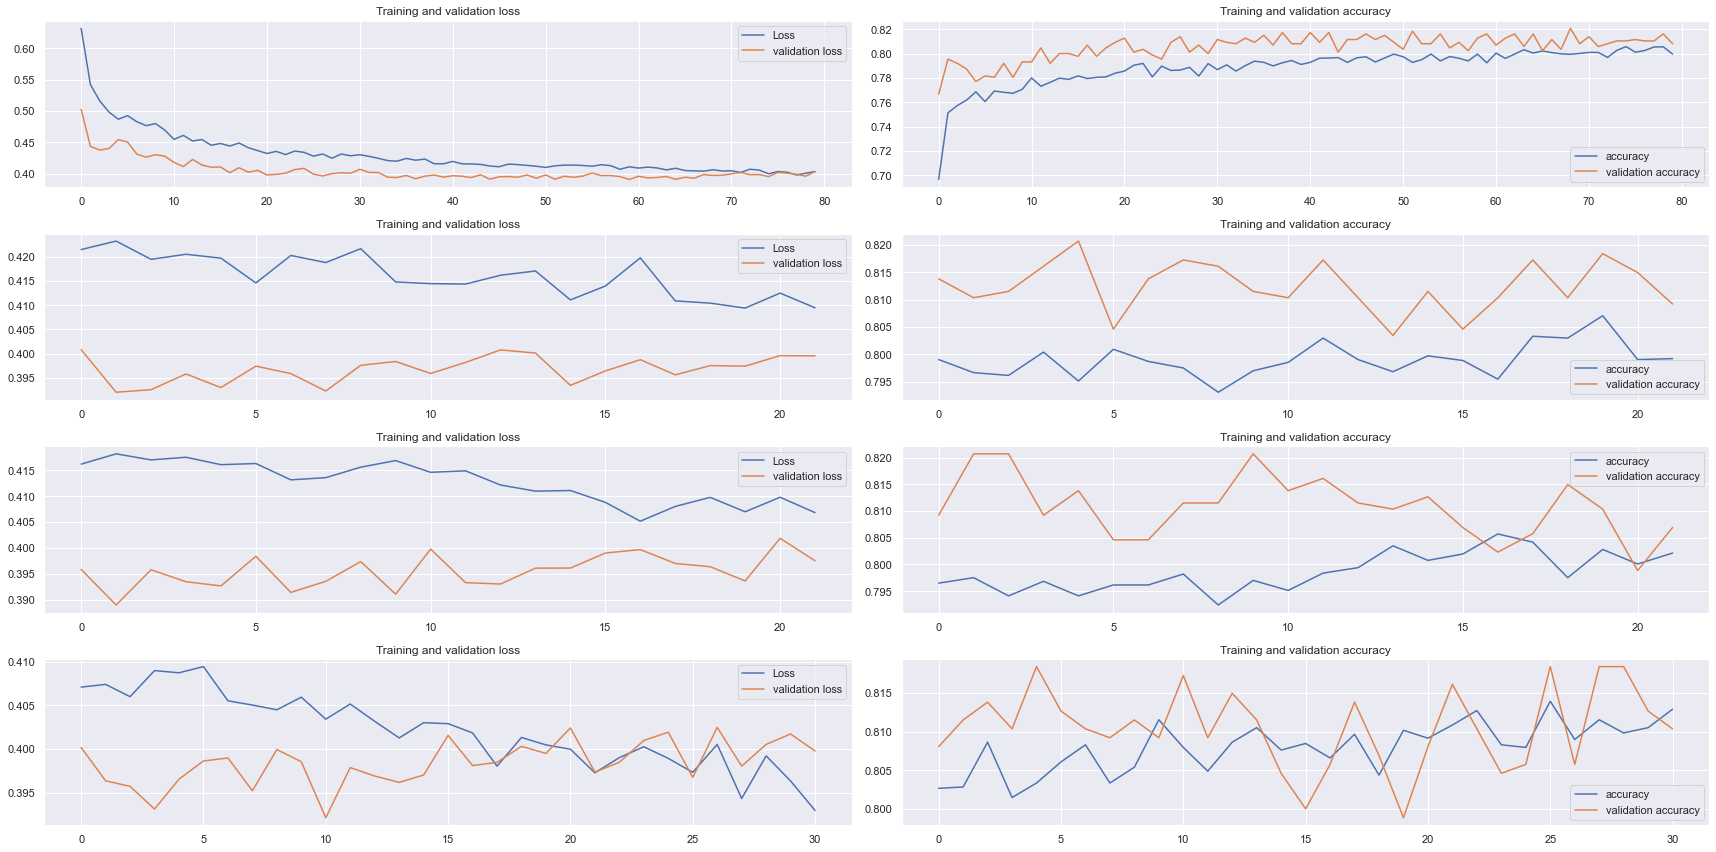

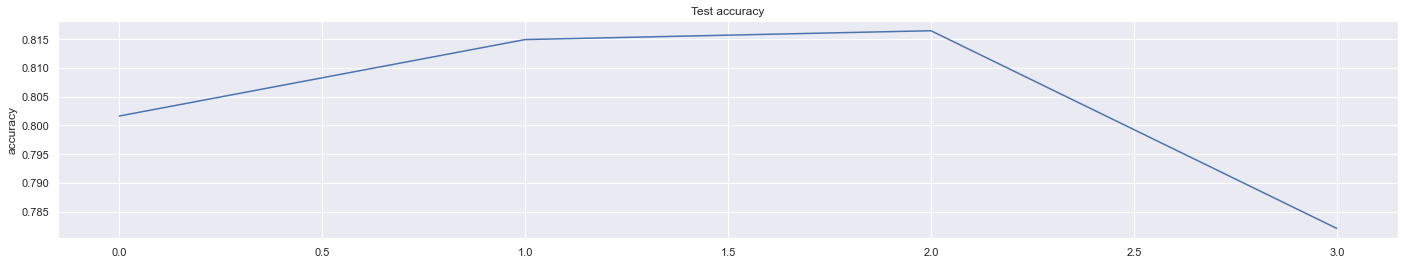

In [463]:
training_evaluate_results = pd.DataFrame([h["evaluateResult"] for h in history_result], columns=["loss", "accuracy"])

_, axs = plt.subplots(len(history_result), 2, figsize=(24, 12))

for h_idx, h in enumerate(history_result):
    hist = h["history"]
    loss = hist["loss"]
    acc = hist["binary_accuracy"]
    val_loss = hist["val_loss"]
    val_accuracy = hist["val_binary_accuracy"]

    sns.lineplot(x=np.arange(0, len(loss)), y=loss, ax=axs[h_idx][0], label="Loss")
    sns.lineplot(x=np.arange(0, len(acc)), y=acc, ax=axs[h_idx][1], label="accuracy")

    sns.lineplot(x=np.arange(0, len(val_loss)), y=val_loss, ax=axs[h_idx][0], label="validation loss")
    sns.lineplot(x=np.arange(0, len(val_accuracy)), y=val_accuracy, ax=axs[h_idx][1], label="validation accuracy")

    axs[h_idx][0].set_title("Training and validation loss")
    axs[h_idx][1].set_title("Training and validation accuracy")

plt.tight_layout()
plt.show()

_, axs = plt.subplots(1, 1, figsize=(24, 4))
sns.lineplot(data=training_evaluate_results, x=training_evaluate_results.index, y="accuracy")
axs.set_title("Test accuracy")
plt.show()

In [464]:
test_ds = dataframe_to_dataset(test_data[NUMERICAL_FEATURES + BOOL_FEATURES + CATEGORICAL_FEATURES], shuffle=False)

y_predictions = 1 * (model.predict(test_ds) > 0.5)
test_results = pd.concat([test_data["PassengerId"].reset_index(drop=True), pd.DataFrame(y_predictions, columns=["Transported"])], axis=1)
test_results["Transported"] = test_results["Transported"].astype(bool)
test_results.to_csv("submissionNN.csv", index=False)

4277/4277 [==============================] - 7s 2ms/step


In [465]:
!kaggle competitions submit -c spaceship-titanic -f submissionNN.csv -m "second submit"

100%|██████████████████████████████████████| 56.3k/56.3k [00:01<00:00, 32.1kB/s]
Successfully submitted to Spaceship Titanic